# Using the Edge Impulse Python SDK with TensorFlow and Keras

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edgeimpulse/notebooks/blob/master/notebooks/01-python-sdk-with-tf-keras.ipynb)

[TensorFlow](https://www.tensorflow.org/) is an open source library for training machine learning models. [Keras](https://keras.io/) is an open source Python library that makes creating neural networks in TensorFlow much easier. We use these two libraries together to very quickly train a model to identify handwritten digits. From there, we use the Edge Impulse Python SDK library to profile the model to see how inference will perform on a target edge device. Then, we use the SDK again to convert our trained model to a C++ library that can be deployed to an edge hardware platform, such as a microcontroller.

Follow the code below to see how to train a simple machine learning model and deploy it to a C++ library using Edge Impulse.

To learn more about using the Python SDK, please see: [Edge Impulse Python SDK Overview](https://docs.edgeimpulse.com/docs/edge-impulse-python-sdk/overview.md)

In [ ]:
# If you have not done so already, install the following dependencies
!python -m pip install tensorflow edgeimpulse

In [ ]:
from tensorflow import keras
import edgeimpulse as ei

You will need to obtain an API key from an Edge Impulse project. Log into [edgeimpulse.com](https://edgeimpulse.com/) and create a new project. Open the project, navigate to **Dashboard** and click on the **Keys** tab to view your API keys. Double-click on the API key to highlight it, right-click, and select **Copy**.

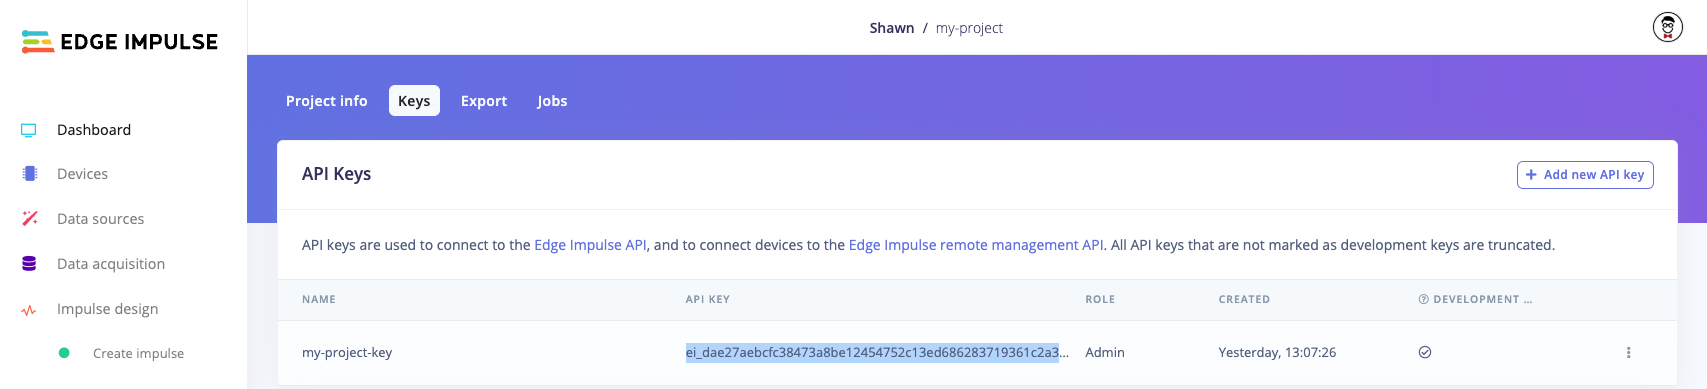

Note that you do not actually need to use the project in the Edge Impulse Studio. We just need the API Key.

Paste that API key string in the `ei.API_KEY` value in the following cell:

In [ ]:
# Settings
ei.API_KEY = "ei_dae27aebcfc38473a8be12454752c13ed686283719361c2a32359f62c6727711" # Change this to your Edge Impulse API key
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(labels)
savedmodel_name = "my_model"
deploy_filename = "my_model_cpp.zip"

## Train a machine learning model

We want to create a classifier that can uniquely identify handwritten digits. To start, we will use TensorFlow and Keras to train a very simple convolutional neural network (CNN) on the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which consists of handwritten digits from 0 to 9.

Once we have trained the model, we save it in a folder named `"my_model"` using the [SavedModel](https://www.tensorflow.org/guide/saved_model) format.

In [ ]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
input_shape = x_train[0].shape

In [ ]:
# Build the model 
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu', input_shape=input_shape),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(x_train, 
          y_train, 
          epochs=5)

In [ ]:
# Evaluate model on test set
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

In [ ]:
# Save model to SavedModel format
model.save(savedmodel_name)

## Profile your model

Use the Edge Impulse Python SDK to generate a profile for your model to ensure it fits on your target hardware and meets your timing requirements.

In [ ]:
# Generate a profile from your model and print the results
try:
    resp_profile = ei.model.profile(model=savedmodel_name,
                                    device='cortex-m4f-80mhz')
    print(resp_profile)
except Exception as e:
    print(f"Could not run profile: {e}")

## Deploy your model

Once you are happy with the performance of the model, you can deploy it to a number of possible hardware targets. The most generic target is to download a .zip file containing a C++ library containing the inference runtime and your trained model. To do that, we first need to create a ModelInfo object, which contains our label strings (and other optional information about the model).

In [ ]:
# Set model information, such as your list of labels
model_type = ei.model_info.Classification(labels=labels)

# Create C++ library with trained model
try:
    deploy_bytes = ei.model.deploy(model=savedmodel_name,
                                   model_output=model_type,
                                   deploy_target='zip')
except Exception as e:
    print(f"Could not deploy: {e}")
    
# Write the downloaded raw bytes to a file
with open(deploy_filename, 'wb') as f:
    f.write(deploy_bytes)

You are now ready to use your C++ model in your embedded and edge device application! See our documentation [here](